In [ ]:
#PROBLEM STATEMENT: 
'''
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics 
to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company 
has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.
The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using 
regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
Which variables are significant in predicting the price of a house, and
How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

Business Goal:
You are required to model the price of houses with the available independent variables. This model will then be used by the 
management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the 
firm and concentrate on areas that will yield high returns. 
'''

In [59]:
# importing the required libraries
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics, linear_model

import warnings
warnings.filterwarnings('ignore')

In [60]:
surprise = pd.read_csv(r'D:\Everything_Tech\Python_DS__ML\upGrad_ML_AI\Course_4\Module_2_Assignment_Advanced_Regression\Datasets\train.csv')

In [61]:
round(100*(surprise.isnull().sum()/len(surprise.index)), 2)

surprise = surprise.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1)

In [62]:
'''
As per data dictionary its observed that there are many categorical column where 
the value is None or NA but in the data those populated as NaN. Imputing back those 
with value as 'None'. Below are the columns from data dictionary 'BsmtQual',
'BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtCond','GarageType','GarageQual',
'GarageCond', 'GarageFinish','MasVnrType'
'''

cols = ['BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtCond','GarageType','GarageQual','GarageCond', 'GarageFinish','MasVnrType']
surprise[cols] = surprise[cols].fillna('None')

<AxesSubplot:xlabel='MasVnrArea'>

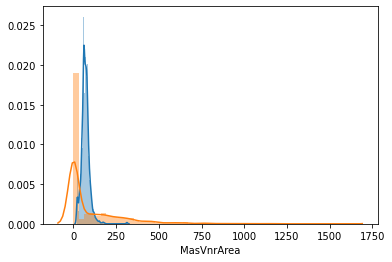

In [63]:
# drawing distplots for some of the variables 
sns.distplot(surprise.LotFrontage) 
sns.distplot(surprise.MasVnrArea) 

In [64]:
# some columns have only some missing values, and we remove them
surprise = surprise.dropna(subset = ['LotFrontage', 'Electrical', 'MasVnrArea'])

In [65]:
round(100*(surprise.isnull().sum()/len(surprise.index)), 2)

Id               0.0
MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
                ... 
MoSold           0.0
YrSold           0.0
SaleType         0.0
SaleCondition    0.0
SalePrice        0.0
Length: 77, dtype: float64

In [66]:
# Id is a useless column so we drop it 
surprise = surprise.drop(['Id'], axis = 1)

In [67]:
# outlier analysis
surprise.describe().transpose()
# there are a lot of columns where median is zero 

cols = surprise.select_dtypes(include = ['float64', 'int64'])
cols = [i for i in cols if round((surprise[(surprise[i] == 0)][i].count()/len(surprise.index))*100,2)>=80]
surprise = surprise.drop(cols, axis = 1)
surprise.shape

(1194, 68)

In [68]:
# EDA: Checking if there are any duplicate rows 
surprise.duplicated().sum()
# there are none

0

In [69]:
# Now we will be deriving some new metrics and along with that dropping some columns
surprise['HouseAge'] = surprise['YrSold'] - surprise['YearBuilt']
surprise['RemodelAge'] = surprise['YrSold'] - surprise['YearRemodAdd']

# dropping the fearures used to derive the above metrics 
surprise = surprise.drop(['YearBuilt', 'YearRemodAdd'], axis = 1)

# above derived metrics seem to have some negative values, which does not make any sense 
# so we drop them 
surprise = surprise[~surprise['HouseAge']<0]
surprise = surprise[~surprise['RemodelAge']<0]

In [70]:
# there is a column that tells the month when the house was built. We label encode it 
surprise.MoSold = surprise.MoSold.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

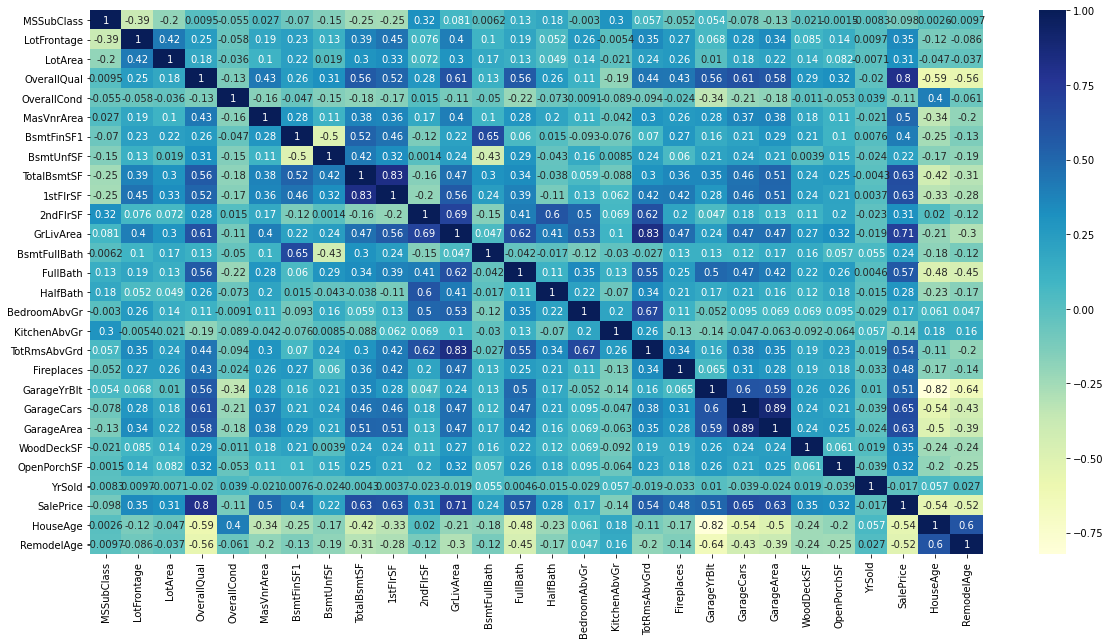

In [71]:
# EDA: Making a heatmap and checking the correlation values 
cor_sn = surprise.corr()

plt.figure(figsize = (20, 10))
sns.heatmap(cor_sn, cmap = 'YlGnBu', annot = True)

# Following columns have high correlations between them:
# GarageYrBlt & AgeOfHouse (0.82) 
# 1stFlrSF & TotalBsmtSF (0.83) 
# GrLivArea & TotRmsAbvGrd (0.83)
# GarageCars & GarageArea (0.89)

# we drop the following: GarageYrBlt, TotalBsmtSF, TotRmsAbvGrd, GarageCars

surprise = surprise.drop(['GarageYrBlt','TotalBsmtSF', 'TotRmsAbvGrd','GarageCars'], axis = 1)

In [72]:
# now we see if there are any values in categorical features that occur a high, say 80%+ times
cols = surprise.select_dtypes(include = ['object'])
cols = [i for i in cols if round(list(surprise[i].value_counts(normalize = True).sort_values(ascending = False).head(1))[0]*100,2)>=80]
# we drop such 80%+ times features
surprise = surprise.drop(cols, axis = 1)

In [73]:
# Now we create the dummy variables 
cols = surprise.select_dtypes(include = ['object'])
dummies = pd.get_dummies(cols, drop_first = True)
surprise = surprise.drop(list(cols.columns), axis = 1)
surprise = pd.concat([surprise, dummies], axis = 1)

# a little check to see if any categorical columns are left or not 
len(list(surprise.select_dtypes(include=['object']).columns))==0

True

In [74]:
# now we split and scale the data

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
surprise[surprise.columns] = scaler.fit_transform(surprise[surprise.columns])

from sklearn.model_selection import train_test_split
np.random.seed(0)
surprise_train, surprise_test = train_test_split(surprise, train_size=0.7, test_size = 0.3, random_state=100)



y_train = surprise_train.pop('SalePrice')
X_train = surprise_train
y_test = surprise_test.pop('SalePrice')
X_test = surprise_test

In [75]:
# using RFE for feature selection
from sklearn.feature_selection import RFE

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 30)
rfe.fit(X_train, y_train)

rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

X_train_rfe = X_train[rfe_sel_columns]
X_test_rfe = X_test[rfe_sel_columns]

In [76]:
# here we assign a lot of learning rate values to alpha
alpha = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
folds = 5

In [77]:
# Now we first perform the ridge regression
ridge = Ridge()
model_r = GridSearchCV(estimator = ridge, 
                        param_grid = alpha, 
                        scoring = 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_r.fit(X_train_rfe, y_train)

results_r = pd.DataFrame(model_r.cv_results_)
results_r = results_r[results_r['param_alpha']<=200]

results_r['param_alpha'] = results_r['param_alpha'].astype('int32')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.8s finished


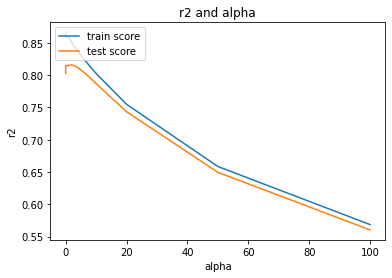

In [78]:
# plotting 
plt.plot(results_r['param_alpha'], results_r['mean_train_score'])
plt.plot(results_r['param_alpha'], results_r['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [79]:
model_r.best_params_

alpha_ridge = model_r.best_params_['alpha']
ridge = Ridge(alpha=alpha_ridge)
ridge.fit(X_train_rfe, y_train)
ridge.coef_

y_train_pred_ridge = ridge.predict(X_train_rfe)
y_test_pred_ridge = ridge.predict(X_test_rfe)

In [80]:

from sklearn.metrics import r2_score
r2_train_ridge = round(r2_score(y_train, y_train_pred_ridge),4)
r2_train_ridge

r2_test_ridge = round(r2_score(y_test, y_test_pred_ridge),4)
r2_test_ridge


model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train_rfe.columns
cols = cols.insert(0, "constant")
sorted(list(zip(cols, model_parameters)),key=lambda x: abs(x[1]),reverse=True)

[('GrLivArea', 0.278),
 ('OverallQual', 0.176),
 ('LotArea', 0.111),
 ('constant', 0.1),
 ('Neighborhood_NoRidge', 0.092),
 ('GarageArea', 0.088),
 ('ExterQual_TA', -0.068),
 ('Neighborhood_StoneBr', 0.063),
 ('BsmtQual_None', -0.062),
 ('BsmtQual_Fa', -0.059),
 ('BsmtQual_TA', -0.059),
 ('HouseAge', -0.056),
 ('LotShape_IR3', -0.054),
 ('OverallCond', 0.053),
 ('BsmtFullBath', 0.052),
 ('BsmtQual_Gd', -0.052),
 ('ExterQual_Fa', -0.051),
 ('ExterQual_Gd', -0.051),
 ('Neighborhood_Crawfor', 0.044),
 ('Neighborhood_NridgHt', 0.043),
 ('MSSubClass', -0.041),
 ('Exterior1st_ImStucc', -0.031),
 ('Exterior2nd_ImStucc', 0.027),
 ('GarageType_BuiltIn', 0.023),
 ('KitchenAbvGr', -0.016),
 ('Exterior2nd_CmentBd', 0.014),
 ('GarageType_None', 0.012),
 ('LotFrontage', -0.009),
 ('Exterior1st_CemntBd', -0.008),
 ('GarageType_Attchd', 0.008),
 ('GarageType_CarPort', -0.002)]

In [82]:
top5_ridge = [x[0] for x in sorted(list(zip(cols, model_parameters)),key=lambda x: abs(x[1]),reverse=True) if x[0] != 'constant'][:6]
top5_ridge

['GrLivArea',
 'OverallQual',
 'LotArea',
 'Neighborhood_NoRidge',
 'GarageArea',
 'ExterQual_TA']

In [92]:
lasso = Lasso()
model_l = GridSearchCV(estimator = lasso, 
                        param_grid = alpha, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_l.fit(X_train_rfe, y_train)

results_l = pd.DataFrame(model_l.cv_results_)
results_l = results_l[results_l['param_alpha']<=0.01]
results_l.head()

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    3.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.018202,0.003600,0.0072,0.000748,0.0001,{'alpha': 0.0001},0.644333,0.784032,0.908776,0.802359,...,0.808555,0.096566,1,0.893642,0.861460,0.849382,0.864865,0.847894,0.863449,0.016477
1,0.011201,0.001327,0.0068,0.001600,0.001,{'alpha': 0.001},0.722661,0.729657,0.883785,0.766390,...,0.788008,0.062880,2,0.838649,0.808737,0.796576,0.804574,0.792919,0.808291,0.016181
2,0.009601,0.001357,0.0056,0.001200,0.01,{'alpha': 0.01},0.392409,0.268656,0.474280,0.323736,...,0.350922,0.074180,3,0.350697,0.370974,0.342456,0.365134,0.383181,0.362488,0.014474


In [94]:
# mean test and train scoes with alpha 
results_l['param_alpha'] = results_l['param_alpha'].astype('float32')

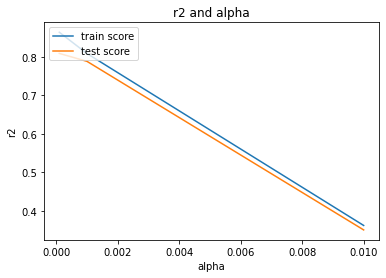

In [95]:
# plotting
plt.plot(results_l['param_alpha'], results_l['mean_train_score'])
plt.plot(results_l['param_alpha'], results_l['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')

plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [97]:
# Checking the best parameter(Alpha value)
model_l.best_params_

alpha_lasso = model_l.best_params_['alpha']
lasso = Lasso(alpha=alpha_lasso)   
lasso.fit(X_train_rfe, y_train)

Lasso(alpha=0.0001)

In [98]:
# Predicting the target variable for both train and test data
y_train_pred_lasso = lasso.predict(X_train_rfe)
y_test_pred_lasso = lasso.predict(X_test_rfe)

In [99]:
# R2 score for both train and test data predicted above
r2_train_lasso = round(r2_score(y_train, y_train_pred_lasso),4)
r2_train_lasso
r2_test_lasso = round(r2_score(y_test, y_test_pred_lasso),4)
r2_test_lasso

0.8818

In [100]:
# Coeffients for features selected by the model
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train_rfe.columns
cols = cols.insert(0, "constant")
sorted(list(zip(cols, model_parameters)),key=lambda x: abs(x[1]),reverse=True)

[('GrLivArea', 0.386),
 ('LotArea', 0.243),
 ('OverallQual', 0.171),
 ('LotShape_IR3', -0.099),
 ('constant', 0.092),
 ('Neighborhood_NoRidge', 0.081),
 ('HouseAge', -0.077),
 ('GarageArea', 0.066),
 ('Neighborhood_StoneBr', 0.065),
 ('ExterQual_TA', -0.063),
 ('BsmtQual_None', -0.059),
 ('OverallCond', 0.058),
 ('BsmtQual_TA', -0.053),
 ('BsmtFullBath', 0.052),
 ('BsmtQual_Fa', -0.052),
 ('ExterQual_Gd', -0.049),
 ('BsmtQual_Gd', -0.049),
 ('MSSubClass', -0.048),
 ('LotFrontage', -0.047),
 ('ExterQual_Fa', -0.046),
 ('Neighborhood_NridgHt', 0.045),
 ('Neighborhood_Crawfor', 0.039),
 ('KitchenAbvGr', -0.024),
 ('Exterior2nd_ImStucc', 0.023),
 ('GarageType_BuiltIn', 0.01),
 ('GarageType_None', 0.008),
 ('Exterior2nd_CmentBd', 0.006),
 ('GarageType_Attchd', 0.002),
 ('Exterior1st_CemntBd', 0.0),
 ('Exterior1st_ImStucc', -0.0),
 ('GarageType_CarPort', 0.0)]

In [101]:
# Top 5 features selected as part of model
top5_lasso = [x[0] for x in sorted(list(zip(cols, model_parameters)),key=lambda x: abs(x[1]),reverse=True) if x[0] != 'constant'][:6]
top5_lasso

['GrLivArea',
 'LotArea',
 'OverallQual',
 'LotShape_IR3',
 'Neighborhood_NoRidge',
 'HouseAge']